## 1. Load Necessary Libraries

In [39]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import os
import datetime as dt
import torch
from sklearn.preprocessing import StandardScaler

## 2. Set seed for reproducibility

In [13]:
# -----------------------------
# Reproducibility
# -----------------------------
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

if torch.cuda.is_available():
    print("CUDA is available. Setting seed for all GPUs.")
    torch.cuda.manual_seed_all(RANDOM_SEED)

sns.set_style("darkgrid")


CUDA is available. Setting seed for all GPUs.


## 3. Set paths

In [16]:
# -----------------------------
# Project Root Resolution
# -----------------------------
PROJECT_ROOT = Path.cwd().resolve().parents[0]

DATA_RAW_DIR = PROJECT_ROOT / "data" / "raw"
DATA_INTERIM_DIR = PROJECT_ROOT / "data" / "interim"
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"

DATA_INTERIM_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

DATA_RAW_DIR, DATA_INTERIM_DIR, FIGURES_DIR


(WindowsPath('C:/Users/Kinjal Mitra/Documents/stock-price-prediction-ff/data/raw'),
 WindowsPath('C:/Users/Kinjal Mitra/Documents/stock-price-prediction-ff/data/interim'),
 WindowsPath('C:/Users/Kinjal Mitra/Documents/stock-price-prediction-ff/reports/figures'))

## 4. Load Data from data/raw/

In [28]:
data_path = DATA_RAW_DIR / "Data.csv"
price_path = DATA_RAW_DIR / "StockPrice.csv"

df_data = pd.read_csv(data_path, parse_dates=["Date"])
df_price = pd.read_csv(price_path, parse_dates=["Date"])


In [29]:
print("\n df_data: \n", df_data.head(5))
print("\n df_price: \n", df_price.head(5))


 df_data: 
         Date   Data
0 2025-03-26  2.369
1 2025-03-25  2.365
2 2025-03-24  2.367
3 2025-03-21  2.386
4 2025-03-20  2.387

 df_price: 
         Date    Price
0 2025-03-26  5759.50
1 2025-03-25  5826.50
2 2025-03-24  5815.50
3 2025-03-21  5718.25
4 2025-03-20  5712.75


## 5. Basic Checks

In [30]:
# Sort and set Date as index
df_data = df_data.sort_values("Date").set_index("Date")
df_price = df_price.sort_values("Date").set_index("Date")

# Date Range
print("Data dataset range:", df_data.index.min(), "→", df_data.index.max())
print("Price dataset range:", df_price.index.min(), "→", df_price.index.max())

# Null Value check
print("\nNull values:")
print(df_data.isna().sum())
print(df_price.isna().sum())


Data dataset range: 2010-01-04 00:00:00 → 2025-03-26 00:00:00
Price dataset range: 2010-01-04 00:00:00 → 2025-03-26 00:00:00

Null values:
Data    0
dtype: int64
Price    0
dtype: int64


In [31]:
# Ensure perfect date alignment
assert df_data.index.equals(df_price.index), "Date indices do not match!"

AssertionError: Date indices do not match!

## 6. Merge Dataset

In [32]:
df = pd.concat(
    [
        df_data.rename(columns={"Data": "data_value"}),
        df_price.rename(columns={"Price": "price"})
    ],
    axis=1
)

df.head()


,data_value,price
Date,,
2010-01-04,0.700,1178.00
2010-01-05,0.699,1181.50
2010-01-06,0.694,1182.25
2010-01-07,0.692,1186.75
2010-01-08,0.691,1190.75


## 7. Visual Checks

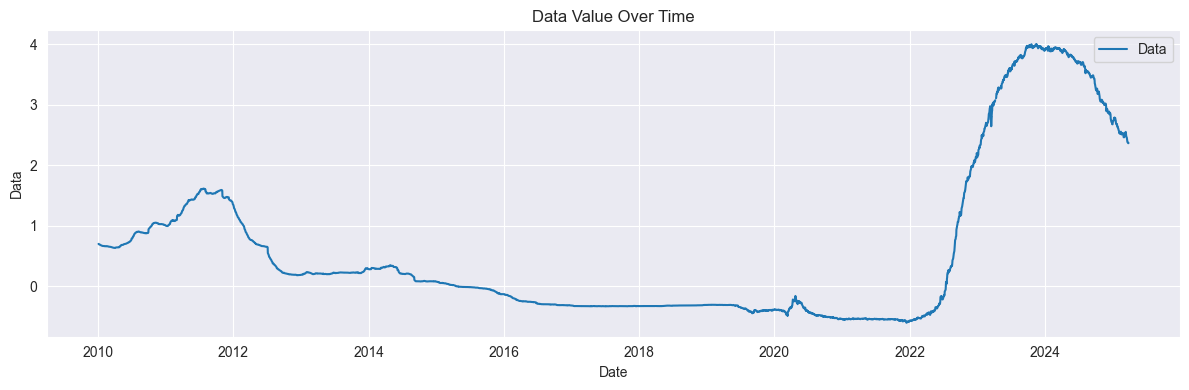

In [33]:
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["data_value"], label="Data", color="tab:blue")
plt.title("Data Value Over Time")
plt.xlabel("Date")
plt.ylabel("Data")
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "data_timeseries.png")
plt.show()


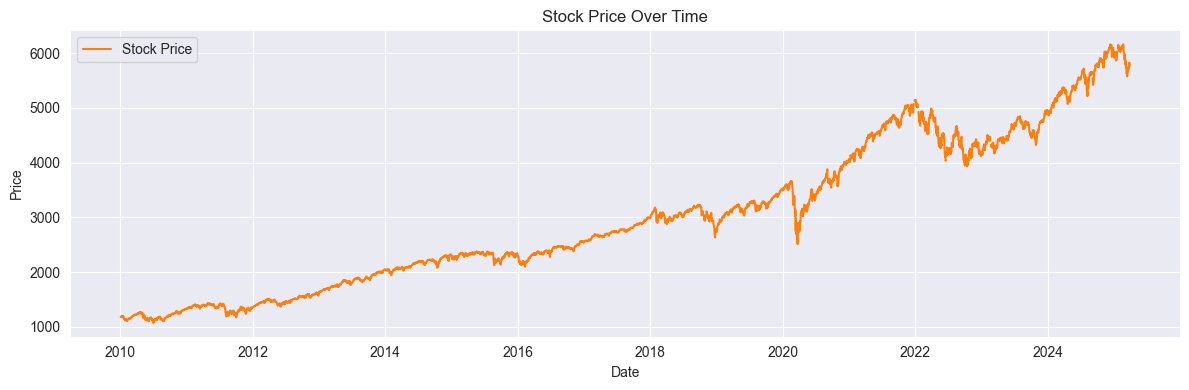

In [34]:
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["price"], label="Stock Price", color="tab:orange")
plt.title("Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "price_timeseries.png")
plt.show()


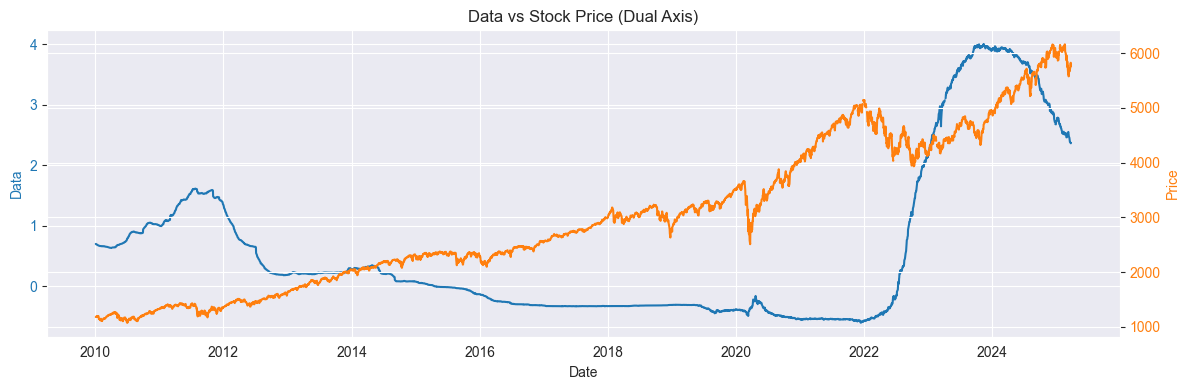

In [35]:
# Dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 4))

ax1.set_xlabel("Date")
ax1.set_ylabel("Data", color="tab:blue")
ax1.plot(df.index, df["data_value"], color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Price", color="tab:orange")
ax2.plot(df.index, df["price"], color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

plt.title("Data vs Stock Price (Dual Axis)")
fig.tight_layout()
plt.savefig(FIGURES_DIR / "data_vs_price_dual_axis.png")
plt.show()


## 8. Feature Engineering
- Create features from existing data

In [36]:
df_feat = df.copy()

# -----------------------------
# Data-based features
# -----------------------------
df_feat["data_diff"] = df_feat["data_value"].diff()
df_feat["data_pct_change"] = df_feat["data_value"].pct_change()

# -----------------------------
# Price-based autoregressive feature
# -----------------------------
df_feat["price_lag_1"] = df_feat["price"].shift(1)

# Drop initial rows created due to lagging
df_feat = df_feat.dropna()

df_feat.head()


C:\temp\ipykernel_4032\3733165841.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_feat["data_pct_change"] = df_feat["data_value"].pct_change()


,data_value,price,data_diff,data_pct_change,price_lag_1
Date,,,,,
2010-01-05,0.699,1181.50,-0.001,-0.001429,1178.00
2010-01-06,0.694,1182.25,-0.005,-0.007153,1181.50
2010-01-07,0.692,1186.75,-0.002,-0.002882,1182.25
2010-01-08,0.691,1190.75,-0.001,-0.001445,1186.75
2010-01-11,0.689,1191.75,-0.002,-0.002894,1190.75


## 9. Lag Depth as a Hyperparameter (Preview Utility)
- Prepare reusable lag-generation logic
- This will later move to features.py

In [37]:
def add_lag_features( df: pd.DataFrame, column: str, max_lag: int) -> pd.DataFrame:
    """
    Add lagged features for a given column.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe
    column : str
        Column to lag
    max_lag : int
        Maximum lag depth

    Returns
    -------
    pd.DataFrame
        DataFrame with lagged features added
    """
    df_out = df.copy()

    for lag in range(1, max_lag + 1):
        df_out[f"{column}_lag_{lag}"] = df_out[column].shift(lag)

    return df_out


In [38]:
# Preview only — modeling phase will control lag depth
df_lagged_preview = add_lag_features(df_feat, column="data_value", max_lag=3)

df_lagged_preview.dropna().head()


,data_value,price,data_diff,data_pct_change,price_lag_1,data_value_lag_1,data_value_lag_2,data_value_lag_3
Date,,,,,,,,
2010-01-08,0.691,1190.75,-0.001,-0.001445,1186.75,0.692,0.694,0.699
2010-01-11,0.689,1191.75,-0.002,-0.002894,1190.75,0.691,0.692,0.694
2010-01-12,0.685,1183.25,-0.004,-0.005806,1191.75,0.689,0.691,0.692
2010-01-13,0.684,1190.75,-0.001,-0.001460,1183.25,0.685,0.689,0.691
2010-01-14,0.682,1194.50,-0.002,-0.002924,1190.75,0.684,0.685,0.689


## 10. Scaling Strategy (Preview)
- Show correct scaling methodology
- Final scaling will happen inside rolling-window logic later

In [40]:
# Temporary split ONLY for demonstrating scaling
split_idx = int(len(df_feat) * 0.8)

train_df = df_feat.iloc[:split_idx]
test_df = df_feat.iloc[split_idx:]

feature_cols = ["data_value", "data_diff", "data_pct_change", "price_lag_1"]

target_col = "price"

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(train_df[feature_cols])
y_train_scaled = y_scaler.fit_transform(train_df[[target_col]])

print("Scaled feature shape:", X_train_scaled.shape)
print("Scaled target shape:", y_train_scaled.shape)


Scaled feature shape: (2934, 4)
Scaled target shape: (2934, 1)


This split is only for demonstrating scaling.
Final evaluation uses walk-forward validation, where scalers are fit per rolling window.

## 11. Final Dataset Check

In [41]:
print("Final dataset shape:", df_feat.shape)
print("\nFeature columns:")
for col in feature_cols:
    print(f" - {col}")

print("\nFeature summary:")
df_feat[feature_cols].describe()


Final dataset shape: (3668, 5)

Feature columns:
 - data_value
 - data_diff
 - data_pct_change
 - price_lag_1

Feature summary:


,data_value,data_diff,data_pct_change,price_lag_1
count,3668.000000,3668.000000,3668.000000,3668.000000
mean,0.579418,0.000453,0.009994,2995.572546
std,1.314548,0.012234,0.581739,1342.704590
min,-0.605000,-0.204000,-2.000000,1080.000000
25%,-0.328000,-0.002000,-0.003165,1927.250000
50%,0.080000,0.000000,0.000000,2753.750000
75%,1.014000,0.001000,0.003922,4214.312500
max,4.002000,0.142000,35.000000,6163.000000


## 12. Save processed data

In [42]:
processed_path = DATA_INTERIM_DIR / "processed_features.csv"
df_feat.to_csv(processed_path)

processed_path


WindowsPath('C:/Users/Kinjal Mitra/Documents/stock-price-prediction-ff/data/interim/processed_features.csv')